# transfer_learning.ipynb

This code is based on pytorch's tutorial.
This uses pre-trained VGG-16 network to identify ant and bee.
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

### Run 'prepare_holder_and_data.ipynb' before run this code.
  - This makes data folder, download dataset, and pathlist. 

### install [tqdm] before run this.
tqdm: visualizing a progress of the training
You can install via anaconda

or conda install -c conda-forge tqdm

### This code The program replaces the last layer of VGG-16 (1000 classes from ImageNet) with two classes of ants and bees, and only re-trains the last 4096(nodes) x2(nodes) connection weights (and biases).

In [2]:
# import package
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

In [12]:
# init random seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

#### Firstly, we confirm the random cropping and color normalization
(as we have seen in the last class)

In [13]:
# preprocessing class for input image
# different processing during the training and testging

class ImageTransform():
    """
    preprocessing class for input image
    resize and perform a color normalization for the input image
    Only at the training, RandomResizeCrop and RandomHorizontalFlip
      as data augmentation (DA)
    In the test phase, 

    Attributes
    ----------
    resize : int
        resized image size
    mean : (R, G, B)
        mean of R,G,B
    std : (R, G, B)
        std of R,G,B
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),  # DA
                transforms.RandomHorizontalFlip(),  # DA
                transforms.ToTensor(),  # convert it to Tensor
                transforms.Normalize(mean, std)  # color normalize
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),  # center crop resize×resize
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            selection of the operation
        """
        return self.data_transform[phase](img)


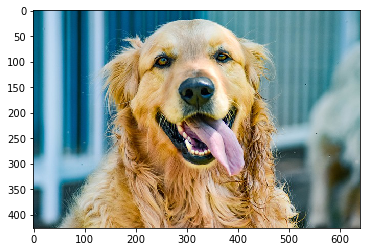

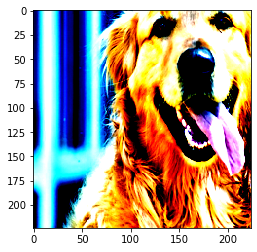

In [14]:
# confirmation of pre-processing at the training
# the resultant image changes in each time

# 1. reaad image
image_file_path = 'goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)   # [H][W][C=RGB]

# 2. display original image
plt.imshow(img)
plt.show()

# 3. display original and processed image
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")  # torch.Size([3, 224, 224])

# Convert (C,H,W) to (H,W,C), normalize it into [0,1], and display
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [15]:

# Build a file-path list for ant and bee images

def make_datapath_list(phase="train"):
    """
    Build a file-path list for data

    Parameters
    ----------
    phase : 'train' or 'val'
        selection of the operation

    Returns
    -------
    path_list : list
        list stored the data path
    """

    rootpath = "./data/hymenoptera_data/"
    target_path = osp.join(rootpath+phase+'/**/*.jpg')
    print(target_path)

    path_list = []  # store here

    # acquire file path to sub-directory with glob
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list


# execution
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

train_list

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


['./data/hymenoptera_data/train\\ants\\0013035.jpg',
 './data/hymenoptera_data/train\\ants\\1030023514_aad5c608f9.jpg',
 './data/hymenoptera_data/train\\ants\\1095476100_3906d8afde.jpg',
 './data/hymenoptera_data/train\\ants\\1099452230_d1949d3250.jpg',
 './data/hymenoptera_data/train\\ants\\116570827_e9c126745d.jpg',
 './data/hymenoptera_data/train\\ants\\1225872729_6f0856588f.jpg',
 './data/hymenoptera_data/train\\ants\\1262877379_64fcada201.jpg',
 './data/hymenoptera_data/train\\ants\\1269756697_0bce92cdab.jpg',
 './data/hymenoptera_data/train\\ants\\1286984635_5119e80de1.jpg',
 './data/hymenoptera_data/train\\ants\\132478121_2a430adea2.jpg',
 './data/hymenoptera_data/train\\ants\\1360291657_dc248c5eea.jpg',
 './data/hymenoptera_data/train\\ants\\1368913450_e146e2fb6d.jpg',
 './data/hymenoptera_data/train\\ants\\1473187633_63ccaacea6.jpg',
 './data/hymenoptera_data/train\\ants\\148715752_302c84f5a4.jpg',
 './data/hymenoptera_data/train\\ants\\1489674356_09d48dde0a.jpg',
 './data/hym

In [16]:
# Build dataset of the ant and bee (hymenoptera) images

class HymenopteraDataset(data.Dataset):
    """
    Dataset class for ants and bee (hymenoptera) images. 
    Extends PyTorch's Dataset class
    
    Attributes
    ----------
    file_list : list
        list stored the image path
    transform : object
        instance of the pre-processing class
    phase : 'train' or 'test'
        selection of the operation
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # list of file-path
        self.transform = transform  # instance of the pre-processing class
        self.phase = phase  # selection of train or val

    def __len__(self):
        '''return the number of images'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        Acquire Tensor format data and labels of pre-processed images.
        '''

        # Load the index-th image
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [H][W][C=RGB]

        # image pre-processing
        img_transformed = self.transform(img, self.phase)  # torch.Size([3, 224, 224])

        # extract label info. from the filename
        if self.phase == "train":
            label = img_path[30:34]
        elif self.phase == "val":
            label = img_path[28:32]

        # convert label name to a number
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1

        return img_transformed, label


# execution
train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

# confirm the data size and label of the first image
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])


torch.Size([3, 224, 224])
0


#### DataLoader provides We use default DataLoader. 
The data loader provides useful features, such as the configuration of mini-batches with random shuffling during training and evaluation. We use default DataLoader.

In [17]:
# Define and build the DataLoaders

# determine the mini-batch size
batch_size = 32

# DataLoaders
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# Put together in a dictionary type variable
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# operation check
batch_iterator = iter(dataloaders_dict["train"])  # convert the training image to iterator
inputs, labels = next(
    batch_iterator)  # extraction of the first element
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 1, 0, 0, 0, 0, 0, 1])


In [18]:
# Load pre-trained VGG-16 network
# Build a VGG-16 model instance
use_pretrained = True  # Use pretrained model
net = models.vgg16(pretrained=use_pretrained)

# Replaced the output unit of the last output layer of the VGG16 with ants and bees
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# set training mode
net.train()

print('network setting done： load pretrained model and set it as the training mode')

network setting done： load pretrained model and set it as the training mode


In [19]:
# setting of the loss function
criterion = nn.CrossEntropyLoss()

### In this transfer learning, only the final weights and biases (classifier.6.weights, classifier.6.bias) are updated. Others are frozen.

In [20]:
# store parameters from transfer learning here.
params_to_update = []

# parameter names to be trained (you can modify)
update_param_names = ["classifier.6.weight", "classifier.6.bias"]

# No gradient calculation except for the parameters to be trained above
# (other 'frozen' weights do not change.)
for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

# see the params_to_update
print("-----------")
print(params_to_update)

classifier.6.weight
classifier.6.bias
-----------
[Parameter containing:
tensor([[ 0.0117,  0.0116,  0.0082,  ..., -0.0072,  0.0059, -0.0065],
        [-0.0071, -0.0131, -0.0117,  ..., -0.0079, -0.0070,  0.0085]],
       requires_grad=True), Parameter containing:
tensor([-0.0087,  0.0008], requires_grad=True)]


In [21]:
# setting of the optimization procedure
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

### Train the VGG-16 network only in the final FC layer.
This code uses GPU if available.

In [22]:
# Define a function to train the model

def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    
    # confirm if GPU is available
    device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    
    print(device)
    
    # epoch loop
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # training and validation in each epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # set network in training mode
            else:
                net.eval()   # set network in test validation mode

            epoch_loss = 0.0  # sum of loss in this epoch
            epoch_corrects = 0  # number of correct prediction in this epoch

            # To evaluate the validation performance before the training (epoch=0)
            #       skip training process when epoch==0
            if (epoch == 0) and (phase == 'train'):
                continue

            # retrieve a mini-batch from a data loader
            for inputs, labels in tqdm(dataloaders_dict[phase]):

                #if GPU is available send inputs to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # initialize an optimizer
                optimizer.zero_grad()

                # forward calculation
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # calculation of the loss
                    _, preds = torch.max(outputs, 1)   # predict label
                    
  
                    # if training mode, use back-propagation to update weights 
                    if phase == 'train':
                        loss.backward()  # calculate gradients using back-prop 
                        optimizer.step() # update weights

                    # calculate results in this iteration
                    # update sum of the loss
                    epoch_loss += loss.item() * inputs.size(0)  
                    # update the number of correct prediction
                    epoch_corrects += torch.sum(preds == labels.data)

            # display loss and accurach in this epoch
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

In [23]:
num_epochs=2 # You can set larger number.
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

cuda:0
Epoch 1/2
-------------


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.8070 Acc: 0.3595
Epoch 2/2
-------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.4874 Acc: 0.7490


100%|██████████| 5/5 [00:01<00:00,  3.14it/s]

val Loss: 0.1885 Acc: 0.9412
